# Assignment 4, part 1
## Instructor: Nidhi Hegde

## Instructions
**Reminder.** You must submit your own work.  The collaboration policy for the assignments is Consultation Collaboration. You may verbally discuss concepts with your classmates, without exchanging written text, code, or detailed advice.  You must develop your own solution and submit your own work.  All sources of information used including books, websites, students you talked to, must be cited in the submission.  Please see the course FAQ document for details on this collaboration policy.  We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.

You must use this notebook to complete your assignment. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided.

Incase any of the packages are not installed on your local system run the following command on your command line and make sure the `requirements.txt` file is also downloaded.
```bash
pip install -r requirements.txt
```

Your submitted notebook should run on our local installation.  So if you are importing packages not listed in the notebook or using local data files not included in the assignment package, make sure the notebook is self-contained with a requirements.txt file or cells in the notebook itself to install the extra packages.  If we cannot run your notebook, you will lose 50% of the marks, and any additional marks that may be lost due to wrong answers.

### Submission Instructions
When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on eClass the notebook file with your work completed. Name your file with your lastname and the assignment number: Lastname_A4-1.ipynb

# Assignment 4: Fairness analysis of the COMPAS Tool

We will consider the fairness case study we examined in class, the ProPublica [investigation](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) tool used in Broward county, Florida, for judicial hearings. COMPAS generates a risk assessment for defendants in a criminal trial, which is then used by judges to decide on bail, jail, sentencing, etc.  As with the ProPublica analysis, we will fcus on the recidivism score.  This score is claimed to give a likelihood of an individual recidivating (committing another crime) within the following two years of the assessment.

In this lab, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

In [1]:
# Don't change this cell; just run it.
!pip install -r requirements.txt
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

# These lines do some fancy plotting magic.
import matplotlib
# This is a magic function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Don't change this cell; just run it.
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

In [3]:
# Downloading the data files from Google Drive
!pip install --upgrade gdown
import gdown
url = "https://drive.google.com/drive/folders/1wQZ8Y6pBGI4UFMb9WZNQa69vM8o7IRmA?usp=drive_link"
gdown.download_folder(url)

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


Retrieving folder contents


Processing file 1zoUwZCxyT80QPM8UHrXXhJT6TdouES_O compas_data_two_years.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1zoUwZCxyT80QPM8UHrXXhJT6TdouES_O
To: /content/data/compas_data_two_years.csv
100%|██████████| 2.54M/2.54M [00:00<00:00, 51.9MB/s]
Download completed


['/content/data/compas_data_two_years.csv']

## Data
We will first load the data, carry out some cleaning and pre-processing, and inspect the data to understand what exploratory steps we will take.

Note that we will use the dataset provided by publica on their github site.  Rather than download the data locally, we will pull the data directly from the github site.  There are a few datasets on the github repository, but we will use one specific one.  The url for the dataset is [https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv)

In [4]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'

# Load the data into a DataFrame
df_init = pd.read_csv(url)

# Display the shape of the DataFrame
print("Shape:", df_init.shape)

# Display the first 5 rows of the DataFrame
print(df_init.head(5))

Shape: (7214, 53)
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custod

In class we exmained the data collection methodology of the ProPublica investigation and analysis.  Make sure you have read through their [methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  It is crucial, in every data analysis project, to have a good understanding of the data.  This includes:  how the data was collected, what sources the data originate from, how data were merged, what the data columns refer to, etc.  You will note that the ProPublica team combined COMPAS tool data they received from a public records request, with public criminal records from the Broward County Clerk’s Office to create the profiles for the individuals in the dataset.  The COMPAS tool output data includes at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear". COMPAS scores for each defendant ranged from 1 to 10, with 10 being the highest risk. Scores from 1 to 4 were labeled by the tool as "Low," 5 to 7 were labeled “Medium," and 8 to 10 were labeled “High.”

### Data pre-processing
We will follow ProPublica's methodology in pre-processing the data.  Note that the data we imported was already filtered so that only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility were included.  In their pre-processing, they first retain only relevant columns, for ease of analysis and inspection.  Then they remove several rows due to missing data.  Form their analysis (paraphrased and commented):
- If the charge date of a defendant's crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, we do not have the right offense. (keep rows `days_b_screening_arrest <= 30` and `days_b_screening_arrest >= -30` )
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all. ( keep rows where `is_recid` is not -1)
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them). (keep rows where `c_charge_degree` is not "O" - note this is the letter O)


We also want to filter out any "N/A" in the `score_text` - note that this column contains strings.

In [5]:
cols_retain = ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]
# Define columns to retain
cols_retain = ["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count",
               "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid",
               "c_jail_in", "c_jail_out"]

# Preprocessing steps
df = df_init.copy()
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]
df = df[df['is_recid'] != -1]
df = df[df['c_charge_degree'] != 'O']
df = df.dropna(subset=['score_text'])

# Retain only relevant columns
df = df[cols_retain]

# Display shape and first 5 rows
print("Shape: ", df.shape)
print(df.head(5))



Shape:  (6172, 13)
   age c_charge_degree              race          age_cat score_text   sex  \
0   69               F             Other  Greater than 45        Low  Male   
1   34               F  African-American          25 - 45        Low  Male   
2   24               F  African-American     Less than 25        Low  Male   
5   44               M             Other          25 - 45        Low  Male   
6   41               F         Caucasian          25 - 45     Medium  Male   

   priors_count  days_b_screening_arrest  decile_score  is_recid  \
0             0                     -1.0             1         0   
1             0                     -1.0             3         1   
2             4                     -1.0             4         1   
5             0                      0.0             1         0   
6            14                     -1.0             6         1   

   two_year_recid            c_jail_in           c_jail_out  
0               0  2013-08-13 06:03:42  2

We will be working with decile_score, which represents the score that the COMPAS tool generates for the individuals.  Let's first be certain the values are numeric.  You would use `pd.to_numeric`.  Note that there might be NaN values, and if so, you should drop those rows.

In [6]:
# Convert decile_score to numeric, coerce errors to NaN
df['decile_score'] = pd.to_numeric(df['decile_score'], errors='coerce')

# Drop rows with NaN values in decile_score
df = df.dropna(subset=['decile_score'])

# Display the shape of the DataFrame
print("Shape: ", df.shape)


Shape:  (6172, 13)


### Data exploration
Let us now explore the statistics of the data.  The compas data includes the `decile_score` which is the score calculated by the COMPAS tool.  Our goal is to compare the analysis of this score, with the outputs of a logistic regression model we will build ourselves.

We will  plot the distribution of the score, according to race to see how they differ.


Let's first create dataframes that are specific to the two races.  In the cell below, create the new dataframes `df_black` and `df_white` so that `df_black` holds all the rows that correspond to the race being "African-American" and `df_white` holds all the rows that correspond to the race being "Caucaisian".

In [7]:
# Filter dataframe for African-American race
df_black = df[df['race'] == 'African-American']

# Filter dataframe for Caucasian race
df_white = df[df['race'] == 'Caucasian']


Now we will plot histograms for these two dataframes.  The histogram will have the Decile Score on the x axis, 10 bins corresponding to the 10 values and the y axis will be the _proportion_ of individuals of each race that have that decile score.  So the y values for each race will be the number of individuals having a given score divided by the total number of individuals of that race.

You can choose how you want to represent the histograms: two separate sub plots side by side, or both on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

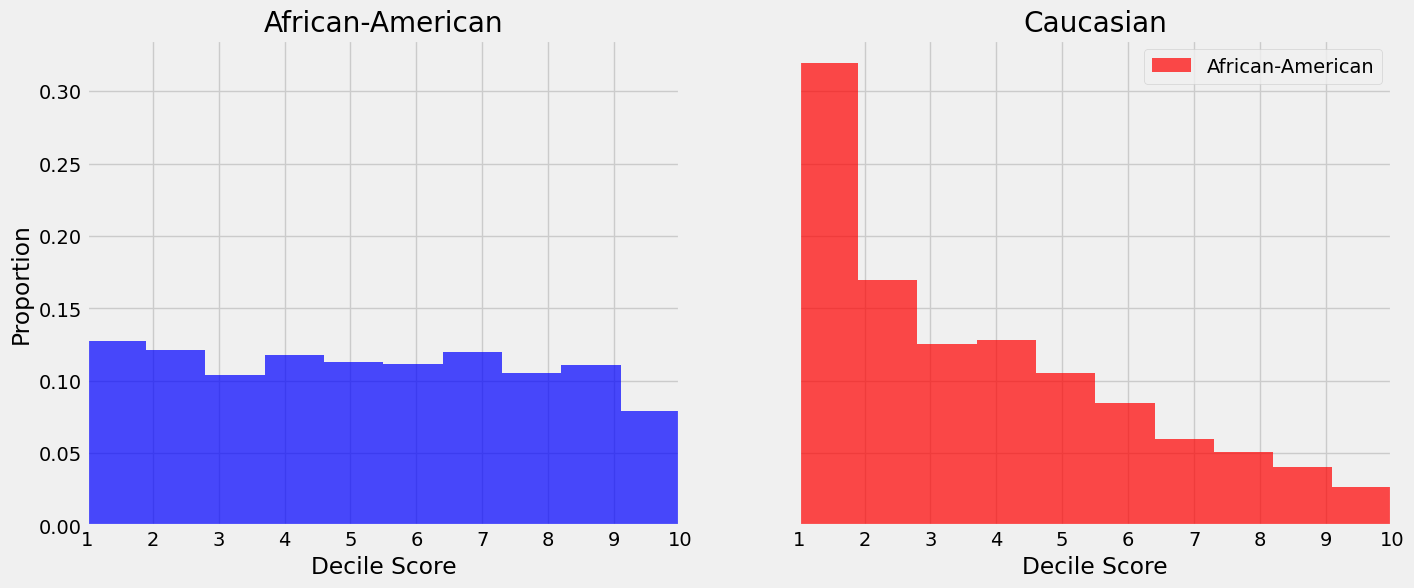

In [8]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Calculate total number of individuals for each race
total_black = len(df_black)
total_white = len(df_white)

# Plot histogram for African-American race
df_black['decile_score'].hist(bins=10, ax=axs[0], color='b', alpha=0.7, density=True)
axs[0].set_title('African-American')
axs[0].set_xlabel('Decile Score')
axs[0].set_ylabel('Proportion')
axs[0].set_xlim(1, 10)

# Plot histogram for Caucasian race
df_white['decile_score'].hist(bins=10, ax=axs[1], color='r', alpha=0.7, density=True)
axs[1].set_title('Caucasian')
axs[1].set_xlabel('Decile Score')
axs[1].set_xlim(1, 10)

# Add legend
plt.legend(['African-American', 'Caucasian'])

# Show plots
plt.show()


#### Question 1
Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the decile scores with respect to the senstive feature race?



**The African-American histogram is quite uniformly distributed while the Caucasian histogram is right skewed.**

**African-American Histogram:** A uniformly distributed histogram for African-Americans indicates that the Violent Decile Scores are fairly evenly spread across the range of scores for this group.

**Caucasian Histogram:** A right-skewed histogram for Caucasians suggests that the majority of Violent Decile Scores for this group are concentrated towards the lower end of the range, with fewer individuals receiving higher scores.

**Implications:** The distribution of Violent Decile Scores by race raises questions about whether the COMPAS tool may exhibit racial bias. For example, if African-Americans are more likely to receive higher scores despite similar risk factors as Caucasians, it could indicate bias in the tool's assessment process.

#### Question 2
We will now consider gender.  Follow the same steps as above, now for the gender feature.

Create dataframes that are specific to the two races.  In the cell below, create the new dataframes `df_male` and `df_female` so that `df_male` holds all the rows that correspond to the sex being "Male" and `df_female` holds all the rows that correspond to the sex being "Female".

In [9]:
# Filter dataframe for Male sex
df_male = df[df['sex'] == 'Male']

# Filter dataframe for Female sex
df_female = df[df['sex'] == 'Female']
df_male
df_female

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,c_jail_in,c_jail_out
8,39,M,Caucasian,25 - 45,Low,Female,0,-1.0,1,0,0,2014-03-15 05:35:34,2014-03-18 04:28:46
12,37,M,Caucasian,25 - 45,Low,Female,0,0.0,1,0,0,2013-01-01 03:28:03,2013-01-02 01:12:19
14,47,F,Caucasian,Greater than 45,Low,Female,1,-20.0,1,1,1,2013-10-10 05:12:58,2013-10-24 11:30:00
23,21,F,Caucasian,Less than 25,Low,Female,0,-2.0,4,0,0,2013-11-20 04:12:09,2013-11-21 07:53:21
36,33,M,Caucasian,25 - 45,Medium,Female,4,-1.0,5,1,1,2013-12-02 01:48:34,2013-12-13 05:25:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7184,36,M,Caucasian,25 - 45,Medium,Female,4,-10.0,6,1,1,2013-07-29 05:40:09,2013-07-31 09:36:16
7194,30,M,Caucasian,25 - 45,Low,Female,2,0.0,1,1,1,2014-12-19 04:46:47,2014-12-20 08:52:23
7200,20,M,African-American,Less than 25,Medium,Female,0,-1.0,7,1,1,2013-11-04 11:13:31,2013-11-09 09:07:40
7212,33,M,African-American,25 - 45,Low,Female,3,-1.0,2,0,0,2014-03-08 08:06:02,2014-03-09 12:18:04


Now we will plot histograms for these two dataframes.  The histogram will have the Decile Score on the x axis, 10 bins corresponding to the 10 values and the y axis will be the _proportion_ of individuals of each sex that have that decile score.  So the y values for each sex will be the number of individuals having a given score divided by the total number of individuals of that sex.

You can choose how you want to represent the histograms: two separate sub plots side by side, or both on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

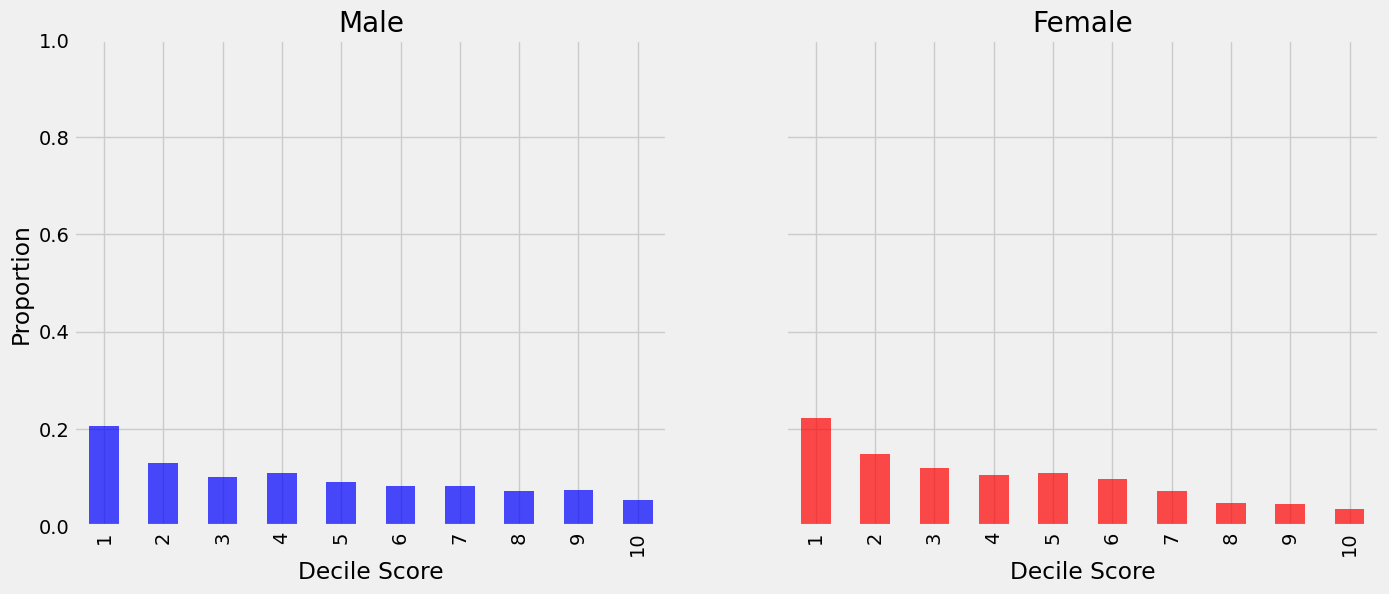

In [10]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Calculate total number of individuals for each sex
total_male = len(df_male)
total_female = len(df_female)

# Plot histogram for Male sex
df_male['decile_score'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axs[0], color='b', alpha=0.7)
axs[0].set_title('Male')
axs[0].set_xlabel('Decile Score')
axs[0].set_ylabel('Proportion')
axs[0].set_ylim(0, 1)

# Plot histogram for Female sex
df_female['decile_score'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axs[1], color='r', alpha=0.7)
axs[1].set_title('Female')
axs[1].set_xlabel('Decile Score')
axs[1].set_ylabel('Proportion')
axs[1].set_ylim(0, 1)

# Show plots
plt.show()


#### Question 3
Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the decile scores with respect to the senstive feature sex?

The two plots show the distribution of decile scores for male and female individuals. Here's an analysis of the differences between them:

1. **Shape of the Distribution:** Both sexes' histograms are similar in shape, with fewer people having higher decile scores (5–10) and the majority of people falling in the lower range (1-4). In contrast to the male distribution, the female distribution seems to be slightly more skewed to the right (higher decile scores).


2. **Proportion of High Decile Scores:** The proportion of individuals with higher decile scores (8-10) is slightly higher among males compared to females. This suggests that, on average, males may receive higher decile scores from the COMPAS tool compared to females.

3. **Consistency Across Decile Scores:** The distribution of decile scores is relatively consistent across the decile range for both sexes, indicating that the COMPAS tool's scoring is not significantly biased towards either sex across different decile levels.

Overall, these plots suggest that while there are some differences in the distribution of decile scores between males and females (male has a higher violent decile score), the overall patterns are quite similar.

****